# Сегментирование клиентов интернет-магазина

**Задача:** сегментировать покупателей интернет-магазина товаров для дома. Сегментация по профилю потребления будет использована в разработке персонализированных предложений для разных сегментов клиентов.

## Предобработка данных

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import itertools

### Загрузка данных 

In [2]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/ecom_dataset_upd.csv')

In [3]:
data.head(5)

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7474 non-null   int64  
 1   customer_id  7474 non-null   object 
 2   order_id     7474 non-null   int64  
 3   product      7474 non-null   object 
 4   quantity     7474 non-null   int64  
 5   price        7474 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 350.5+ KB


In [5]:
print('Минимальная дата в датасете: ', data.date.min(),', максимальная дата в датасете: ', data.date.max())

Минимальная дата в датасете:  2018100100 , максимальная дата в датасете:  2020013115


- Всего в загруженной таблице 7474 строк и 6 столбцов. 
- Данные имеются за период с 01.10.2018 по   31.01.2020.
- Пропусков в данных нет. 
- Типы данных правильные - кроме даты: добавим колонки (1) с датой в формате pd.datetime и (2) с часом соверешения заказа в формате int.

### Проверка на явные и неявные дубликаты

In [6]:
data.duplicated().sum()

0

Явных дубликатов нет

Поиск неявных дубликатов по принципам:

1) одному заказу должен соответствовать один покупатель - несоответсвующие этому принципу заказы удаляем (предварительно убедиться, что доля удаляемых данных не очень большая)

2) одному заказу должно соответствовать одно время заказа - оставим только те строки, которые соответствуют самому позднему времени (предварительно убедиться, что доля удаляемых данных не очень большая)

#### Обработка неявных дубликатов в соответствии с принципом 1

In [7]:
order_to_many_cust = (data
.groupby('order_id')
.agg({'customer_id': 'nunique'})
.query('customer_id > 1')
)
display(order_to_many_cust)
print("Кол-во заказов с id, которому соответствует >1 покупателя:", order_to_many_cust.shape[0])
print("Кол-во строк к удалению:", data[data.order_id.isin(order_to_many_cust.index.values)].shape[0])

,customer_id
order_id,
14872,2
68785,2
69283,2
69310,2
69345,2
69410,2
69485,3
69531,2
69833,2


Кол-во заказов с id, которому соответствует >1 покупателя: 29
Кол-во строк к удалению: 89


In [8]:
#удаление строк
data = data[~(data.order_id.isin(order_to_many_cust.index.values))]
print('Удалили строки с заказами, которым соответсвует > 1 покупателя. Осталось строк: ', data.shape[0] )

Удалили строки с заказами, которым соответсвует > 1 покупателя. Осталось строк:  7385


#### Обработка неявных дубликатов в соответствии с принципом 2

In [9]:
order_to_many_dates = (data
.groupby('order_id')
.agg({'date': 'nunique'})
.query('date > 1')
)
display(order_to_many_dates)
print("Кол-во заказов с id, которому соответствует >1 date:", order_to_many_dates.shape[0])

,date
order_id,
13547,7
14500,4
14504,2
14505,2
14521,6
...,...
73101,2
73104,3
73108,2


Кол-во заказов с id, которому соответствует >1 date: 256


Оставим только строки, соответствующие самому позднему времени оформления заказа.

In [10]:
data = pd.DataFrame(data.groupby(['customer_id', 'order_id', 'product', 'quantity', 'price'])['date'].max().reset_index())
print('Оставили только строки, соответствующие самому позднему времени оформления заказа. Осталось строк:', data.shape[0])

Оставили только строки, соответствующие самому позднему времени оформления заказа. Осталось строк: 5544


### Добавление столбцов 

####  Добавление столбца даты в формате pd.datetime (1) ,  столбца с часом из поля date в формате int (2), столбца month в формате %Y%m (3) и столбца с днем недели (4)

In [11]:
# переименуем столбец date в datehour
data = data.rename(columns={'date': 'datehour'})
# добавим столбец date в формате pd.datetime
data['date'] =  pd.to_datetime([str(i)[:8] for i in data.datehour], format="%Y%m%d")
# добавим столбец hour в формате int
data['hour'] = [int(str(i)[-2:]) for i in data.datehour]

In [12]:
data['month'] = [str(i)[:6] for i in data.datehour]
data['wday'] = data.date.dt.weekday

In [13]:
data.head(5)

,customer_id,order_id,product,quantity,price,datehour,date,hour,month,wday
0,000d6849-084e-4d9f-ac03-37174eaf60c4,14943,Пеларгония зональная диам. 12 см темнорозовая ...,1,150.0,2019101608,2019-10-16,8,201910,2
1,000d6849-084e-4d9f-ac03-37174eaf60c4,14943,Пеларгония розебудная Queen Ingrid укорененный...,1,135.0,2019101608,2019-10-16,8,201910,2
2,000d6849-084e-4d9f-ac03-37174eaf60c4,14943,Пеларгония розебудная Rosebud Red d-7 см,1,135.0,2019101608,2019-10-16,8,201910,2
3,000d6849-084e-4d9f-ac03-37174eaf60c4,14943,Пеларгония тюльпановидная EMMA,1,135.0,2019101608,2019-10-16,8,201910,2
4,001cee7f-0b29-4716-b202-0042213ab038,70290,Сушилка для белья потолочная ЛИАНА ЛЮКС 150 см...,1,442.0,2019021611,2019-02-16,11,201902,5


####  Добавление столбца imcome (кол-во единиц товара умноженное на цену)

In [14]:
data['income'] = data.eval('price * quantity')

In [15]:
data.head(5)

,customer_id,order_id,product,quantity,price,datehour,date,hour,month,wday,income
0,000d6849-084e-4d9f-ac03-37174eaf60c4,14943,Пеларгония зональная диам. 12 см темнорозовая ...,1,150.0,2019101608,2019-10-16,8,201910,2,150.0
1,000d6849-084e-4d9f-ac03-37174eaf60c4,14943,Пеларгония розебудная Queen Ingrid укорененный...,1,135.0,2019101608,2019-10-16,8,201910,2,135.0
2,000d6849-084e-4d9f-ac03-37174eaf60c4,14943,Пеларгония розебудная Rosebud Red d-7 см,1,135.0,2019101608,2019-10-16,8,201910,2,135.0
3,000d6849-084e-4d9f-ac03-37174eaf60c4,14943,Пеларгония тюльпановидная EMMA,1,135.0,2019101608,2019-10-16,8,201910,2,135.0
4,001cee7f-0b29-4716-b202-0042213ab038,70290,Сушилка для белья потолочная ЛИАНА ЛЮКС 150 см...,1,442.0,2019021611,2019-02-16,11,201902,5,442.0


####  Добавление столбца с категорией товара

In [16]:
# для опеределения категории оставим только первое слово в названии продукта 
data['for_cat'] = [x.split()[0].lstrip() for x in data['product']]

In [17]:
print('Топ-20 самых распространенных продуктов:\n', data.for_cat.value_counts().head(20))
print('Всего уникальных значений:', data.for_cat.nunique())

Топ-20 самых распространенных продуктов:
 Пеларгония       732
Рассада          524
Сушилка          300
Сумка-тележка    266
Муляж            184
томата           168
Петуния          154
Гладильная       141
Коврик           126
Герань           112
Чехол            110
Тележка          101
Штора             89
Таз               78
Роза              70
Однолетнее        67
Искусственный     63
Калибрахоа        52
Тарелка           51
Набор             47
Name: for_cat, dtype: int64
Всего уникальных значений: 461


По топ-20 товаров можно предположить, из каких категорий товаров складывается ассортимент интернет-магазина: садовые растения, товары для дома, хозтовары, посуда и комнатные растения. Создадим словарь с категориями и названиями (по первому слову) товаров.

In [18]:
# создаем словарь на основании значений в столбце for_cat
cat_dict = {'Товары для дома': ['Сушилка', 'Ткань', 'Вешалка-перекладина', 'Стеллаж','Штора', 'Чехол','Коврик','Гладильная',\
                                'Скатерть', 'Муляж','Овощеварка','Подрукавник', 'Полотенце', 'Лоток','Обувница-3', 'Покрывало',\
                               'Швабра','Ароматизированное', 'Бальзам', 'Салфетница', 'Вешалки','Соковыжималка',  'Разделочная',\
                               'Плед', 'Махровое', 'Паста', 'Рукав','Ковер', 'Плечики','Ложка', 'Перчатки', 'Полка', \
                                'Вешалка-сушилка', 'Ножеточка', 'Вешалка-плечики','Карниз', 'Мыло', 'Щётка','Весы', 'Линейка,',\
                                'Стремянка-табурет','Вешалка-стойка', 'Сетка',  'Урна-пепельница', 'Ковёр', 'Ополаскиватель', \
                                'Столовая', 'Зубная', 'Сметка', 'Кофр', 'Штанга','Простыня', 'Этажерка', 'Ящик',  'Подушка',\
                                'Петля', 'Щетка-утюжок',   'Наматрасник', 'Нетканые','Простынь','Отбеливатель', 'Фен','Ванна',\
                                'Мантоварка',  'Бельевые','Двуспальное','Утюг','Скалка', 'Чайная','Миксер','Термометр', 'Емкость',\
                                'Кухонные','Ковш', 'Ручка', 'Халат','Ваза','Короб', 'Наматрицник-чехол', 'Стиральный', 'Чистящий',\
                                'Губка','Наволочка', 'Жидкое', 'Пена',  'Пылесос', 'Махровый', 'Сотейник',  'Ключница', 'Соковарка',\
                               'Светильник','Фоторамка', 'Орехоколка','Пододеяльник', 'Мыльница', 'Мыло-скраб','Кондиционер', 'Комод',\
                               'Корзинка', 'Основание', 'Настольная', 'Мантоварка-пароварка', 'Вешалка', 'Комплект' , 'Крючок', \
                                'Корзина', 'Набор', 'Подставка', 'Декоративная', 'Искусственный', 'Подвесное', 'Сиденье', 'Автоматическая',\
                                'Вкладыши', 'Готовая', 'Жестяная', 'Форма', 'Защитный', 'Искусственная', 'Кольца', 'Стяжки', 'Подголовник',\
                               'Сервировочная'] ,
           'Посуда': [ 'Салатник', 'Tepмокружка', 'Термокружка', 'Термос', 'Чайник','Бульонница', 'Контейнер', 'Блюдо',\
                       'Половник', 'Терка', 'Кастрюля', 'Хлебница','Кружка', 'Нож','Мини-сковорода', 'Сковорода', 'Термостакан',\
                       'Масленка','Кувшин','Блюдце', 'Вилка','Толкушка', 'Рыбочистка','Картофелемялка','Стакан','Фарфоровая', \
                     'Противень','Лопатка', 'Венчик', 'Тортница', 'Тарелка', 'Чайный', 'Столовый', 'Универсальный', 'Стеклянная'],
           'Хозтовары': ['Сумка-тележка','Лестница-стремянка', 'Щетка', 'Сумка', 'Фиксатор-шар','Ёрш','Стремянка', 'Фал',\
                        'Стремянки','Стяжка','Подкладка','Мерный', 'Банка','Миска', 'Коробка','Щетка-сметка', 'Окномойка',\
                        'Тряпкодержатель', 'Урна', 'Салфетка', 'Штангенциркуль', 'Совок','Насадка-моп', 'Ролик', 'Скребок',\
                        'Ведро', 'Держатель','Мешок', 'Веник','Пробка',   'Бак','Корыто','Защитная', 'Тряпка','Антинакипин',\
                        'Электроштопор', 'Ерш', 'Наматрацник', 'Одеяло','Крышка','Вантуз',  'Покрытие','Рассекатель', 'Доска',\
                         'Отделитель', 'Шнур', 'Бидон', 'Котел',   'Бензин','Бадан', 'Камнеломка','Измельчитель', 'Лестница',\
                         'Кипятильник','Кухонное', 'Дозатор', 'Овощечистка', 'Концентрат','Сверло-фреза', 'Прищепки','Сверло',\
                         'Антижир', 'Шприц', 'Насадка','Шпагат', 'Пьезозажигалка', 'Вакуумный', 'Просеиватель','Складная', 'Уголок',\
                        'Сито',  'Ручка-скоба', 'Насадка-отжим','Складной', 'Шило', 'Кисточка','Пресс','Веревка','Крепеж', 'Тележка',\
                        'Таз', 'Холодная', 'Гипоаллергенный', 'Завертка', 'Запасная', 'Измерительный', 'Универсальное',\
                         'Многофункциональный', 'Модульная', 'Мусорный', 'Настенная', 'Отжим', 'Петля-стрела', 'Решетка', 'Сверло-фреза,',\
                        'Сменная', 'Сменный', 'Средство'],
           'Комнатные растения': ['Алоэ','Декабрист', 'Комнатное','Антуриум', 'Фиалка', 'Замиокулькас', 'Пеперомия',\
                                  'Хлорофитум', 'Сциндапсус',  'Аспарагус', 'Эхеверия', 'Суккулент','Драцена', 'Каланхое', \
                                 'Калатея','Нолина','Эпипремнум', 'Спатифиллум','Фиттония', 'Диффенбахия','Литопс','Крассула',\
                                 'Хризолидокарпус','Шеффлера','Нефролепис', 'Хамедорея', 'Юкка', 'Фикус', 'Цветущее'],
           'Садовые растения': ['Пеларгония', 'Роза',  'Виола', 'Рассада', 'Бакопа', 'Газания', 'Калибрахоа', 'Львиный',\
                                'Петуния', 'томата', 'Целозия', 'Арбуз', 'Герань', 'Цветок', 'Эхинокактус','Незабудка', \
                                'Тюльпан','Гортензия',   'Клен', 'Чабер',  'Мята', 'Физостегия', 'Гипсофила',  'Гардения',\
                                'Тимьян', 'Аптения',   'Гвоздика', 'Молодило',  'Зверобой', 'Флокс', 'Аквилегия', 'Базилик',\
                                'Горох', 'Земляника', 'Седум', 'Томат', 'Укроп', 'Полки',  'Однолетнее','Примула', 'Эвкалипт',\
                                'Портулак', 'Фаленопсис',  'Бегония', 'Табак', 'Фуксия', 'Бальзамин',  'Ранункулус', 'Огурец',\
                                'Цитрофортунелла', 'Тагетис', 'Космея','Алиссум','Лаватера',  'Вербена', 'Лобелия', 'Азалия', \
                                'Лантана',   'Пуансеттия', 'Мирт',   'Пуансетия',  'Калоцефалус', 'Иссоп', 'Годеция',\
                                'Календула', 'Капуста', 'Кореопсис', 'Лапчатка', 'Цинерария', 'Эшшольция', 'Клубника', \
                                'Кодонанта', 'Циперус',  'Астра', 'Альбука', 'Змееголовник', 'Цикламен','Дыня',  'Настурция',\
                                'Баклажан', 'Патиссон',     'Многолетнее',    'Сахарница',  'Вигна', 'Кабачок', 'Кофе', 'Лавр',\
                                'Сельдерей', 'Тыква',  'Розмарин', 'Овсянница', 'Пахира',   'Буддлея',    'Валериана', \
                                'Любисток', 'Монарда', 'Петрушка', 'Шалфей', 'Котовник','Сантолина',   'Амариллис', 'Мединилла',\
                                'Бархатцы', 'Морковь', 'Гиацинт',  'Георгина',  'Смолевка', 'Цинния', 'Кориандр',  'Мимоза',\
                                'Афеляндра',     'Дендробиум', 'Пиретрум', 'Гербера', 'Душица', 'Мелисса', 'Хризантема','Салат',\
                                'Джункус','Колокольчик', 'Лен', 'Ясколка', 'Лаванда',   'Вербейник', 'Вероника',  'Левкой',\
                               'Бузульник',   'Девичий', 'Солидаго', 'Анемона', 'Нивянник','Каллуна', 'Капсикум', 'Соланум',\
                                'Лук', 'Папоротник', 'Хоста',  'Адиантум', 'Гимнокалициум', 'Аргирантерум',  'Сальвия',\
                                'Подсолнечник', 'Пряные',  'Кампанула',  'Кипарисовик', 'Калла',  'Фатсия', 'Цинерания','Гайлардия',\
                                 'Рудбекия',     'Ель',   'Цикламен,', 'Скиммия',  'Колеус', 'Лилейник', 'Энотера', 'Агератум',\
                                'Маттиола',  'Осина', 'Гиностемма', 'Мускари', 'Барвинок', 'Крокусы',     'Муррайя',  'Синнингия',\
                                'Эхинацея', 'Импатиенс',  'Радермахера','Артемизия', 'Циния',  'Глоксиния', 'Новогоднее', 'Платикодон']
           }


In [19]:
# добавляем столбец с категорией товара
data['category'] = None
for x in data.for_cat:
    for k, v in cat_dict.items():
        if x in v:
            data.loc[data.for_cat ==x, 'category'] = k
            
data.loc[data['category'].isna(), 'category'] = 'Прочее'

In [20]:
print('Кол-во наименований товаров в каждой категории:')
print(data.groupby('category')['product'].nunique())
print('Кол-во купленных единиц товара в каждой категории:')
print(data.groupby('category')['quantity'].sum())

Кол-во наименований товаров в каждой категории:
category
Комнатные растения     67
Посуда                180
Прочее                  8
Садовые растения      866
Товары для дома       846
Хозтовары             367
Name: product, dtype: int64
Кол-во купленных единиц товара в каждой категории:
category
Комнатные растения     219
Посуда                 880
Прочее                 279
Садовые растения      4142
Товары для дома       5224
Хозтовары             3570
Name: quantity, dtype: int64


Выделили 6 категорий товаров на основании названия товара в поле ptoduct. Большая часть ассортимента магазина относится к категориям Садовые растения и Товары для дома. Эти же категории - лидеры по кол-ву проданных единиц товара. Более подробный анализ категорий проведем в следущем разделе.

### Поиск выбросов и аномалий

#### Обработка выбросов в поле с ценой 

count     2685.000000
mean       620.472967
std       1114.550748
min          9.000000
1%          12.000000
50%        187.000000
99%       6017.880000
max      14917.000000
Name: price, dtype: float64

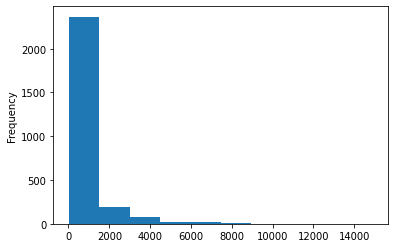

In [21]:
data[['product', 'price']].drop_duplicates().price.plot.hist();
data[['product', 'price']].drop_duplicates().price.describe(percentiles = [0.01, 0.99])

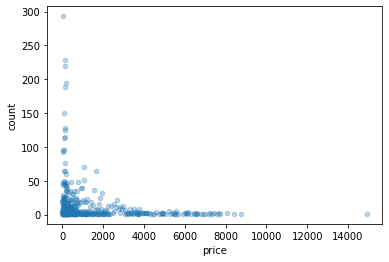

In [22]:
(
    data
    .groupby(['product', 'price'])
    .agg(count  = ('price','count'))
    .reset_index()
    .drop(columns = 'product')
    .groupby('price')['count'].sum().reset_index()
    .plot.scatter(x = 'price', y = 'count', alpha = .3)
);

Большая часть товаров имеет цену до 6000 руб. Есть сотни товаров с одинаковыми очень низкими ценами. Посмотрим внимательнее на обе эти группы и примем решение, что с ними делать.

In [23]:
display(data[data.price > 6000][['product', 'price']].drop_duplicates().sort_values(by = 'product'))

,product,price
433,Автоматическая щетка Leifheit для мытья окон с...,7229.0
3649,Гладильная доска Colombo Avantgard 120х40 см,6614.0
2866,Гладильная доска Leifheit AirBoard Compact M P...,7424.0
2812,Покрывало жаккард KARNA стеганое KALVEN 260x26...,6134.0
812,"Сиденье для гладильной доски Leifheit Niveau, ...",6149.0
4632,Стремянка 7 ступенчатая Hailo 8040-707 XXL 13 ...,7724.0
3600,Сумка-тележка хозяйственная Andersen Alu Star ...,8437.0
4042,Сумка-тележка хозяйственная Andersen Royal Sho...,8737.0
966,Сумка-тележка хозяйственная Andersen Scala Sho...,7199.0
87,Сумка-тележка хозяйственная Andersen Scala Sho...,6149.0


Проверка цен в интернете по наименованиям и брендам продуктов с высокими ценами показала, что цены выглядят правдоподобно, оставляем как есть.

In [24]:
display(data[data.price < 12][['product', 'price']].drop_duplicates().sort_values(by = 'price', ascending = False))

,product,price
942,"Космея Кэнди страйп 0,3 г 4650091480272",11.0
937,"Годеция Рембранд 0,1 г 4650091480128",11.0
950,"Флокс друммонда смесь 0,1 г 4650091480401",11.0
293,"Базилик Смесь зеленого и фиолетового 0,4 г 466...",11.0
1811,Календула Бронзовая красавица 10 шт 4650091480746,11.0
939,"Капуста декоративная смесь 0,1 г 4650091480234",11.0
938,"Календула Пинк сюрпрайз 0,5 г 4650091480203",11.0
2236,"Базилик Застольный 0,3 г 4660010775419",11.0
653,"Лаватера Монт Блан 0,3 г 4660010778588",11.0
4395,"Маттиола Ночная фиалка 0,5 г 4660010770506",11.0


Цены ниже 12 руб за единицу товара выглядят правдопободобно - это преимущественно семена растений, оставим как есть.

Мы посмотрели внимательно на товары из хвостов распределения цены: товары с очень низкими ценами и товары с очень высокими ценами - приняли решение оставить все, как есть, так как все цены выглядят правдоподобно.

#### Обработка выбросов в поле с кол-вом 

count    2968.000000
mean        3.860512
std        22.420817
min         1.000000
1%          1.000000
50%         1.000000
99%        50.000000
max      1000.000000
Name: quantity, dtype: float64

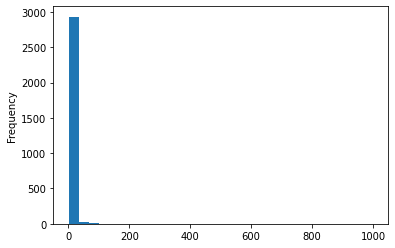

In [25]:
data[['product', 'quantity']].drop_duplicates().quantity.plot.hist(bins = 30);
data[['product', 'quantity']].drop_duplicates().quantity.describe(percentiles = [0.01, 0.99])

Видно, что покупатели онлайн-магазина - розничные клиенты, так как у большинства заказов каждого наименования продукта по несколько штук (пик в районе нуля на гистограмме) и в 99% случаев не превышает 50 штук. Посмотрим внимательнее на заказы, в которых покупатель оформлял >50 штук единиц одного продукта.

In [26]:
data[data.quantity > 50][['product', 'quantity']].drop_duplicates().sort_values(by = 'quantity', ascending = False)

,product,quantity
1032,"Вантуз с деревянной ручкой d14 см красный, Bur...",1000
405,Вешалки мягкие для деликатных вещей 3 шт шоколад,334
2000,Муляж ЯБЛОКО 9 см красное,300
3548,"Ручка-скоба РС-100 белая *Трибатрон*, 1108035",200
3566,Муляж ЯБЛОКО 9 см красное,170
4386,Пружина дверная 240 мм оцинкованная (Д-19 мм) ...,150
2261,Плечики пластмассовые Размер 52 - 54 Тула 1205158,150
4385,"Крепеж для пружины дверной, 1107055",150
242,Муляж ЯБЛОКО 9 см красное,140
55,"Шпингалет 80 мм белый с пружиной, 1102188",100


1000 вантузов, 300+ вешалок и т.д. - кажется, что все строки выше можно удалить, т.к. это выбросы, кол-во их небольшое - на квчество данных удаление строк не повлияет.

In [27]:
data = data[~(data.quantity > 50)]
print('Удалили строки с заказами, у которых quantity > 50 . Осталось строк: ', data.shape[0] )

Удалили строки с заказами, у которых quantity > 50 . Осталось строк:  5521


#### Поиск аномалий среди пользователей
например, совершили неправдоподобно много заказов или слишком много единиц товаров

In [28]:
d = data.groupby('customer_id').agg(count = ('order_id','nunique'), sum_q = ('quantity', 'sum') )
d.describe(percentiles = [.25, .5, .75, .95, .99])

,count,sum_q
count,2394.000000,2394.000000
mean,1.449875,4.446533
std,2.688951,10.916651
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,2.000000
75%,2.000000,3.000000
95%,2.000000,18.350000
99%,3.000000,37.000000
max,125.000000,309.000000


- 99% процентов покупателей совершили не более 3 заказов, посмотрим отдельно на оставшийся 1% покупателей.
- 959% процентов покупателей купили не более 37 товаров за весь период, посмотрим отдельно на оставшийся 1% покупателей.


##### Покупатели более чем с 3 заказами

In [29]:
d.query("count > 3").sort_values(by = "count")

,count,sum_q
customer_id,,
bea7a833-2074-42db-bc49-4457abd3c930,4,30
e0535076-6270-4df2-8621-cb06264a94fa,4,4
0184f535-b60a-4914-a982-231e3f615206,5,58
b7b865ab-0735-407f-8d0c-31f74d2806cc,7,68
73d1cd35-5e5f-4629-8cf2-3fda829d4e58,17,17
4d93d3f6-8b24-403b-a74b-f5173e40d7db,35,309
c971fb21-d54c-4134-938f-16b62ee86d3b,125,270


Покупатели со 35 и 126 заказами - нетипичные покупатели нашего магазина, отбросим их.

In [30]:
data = data[~(data.customer_id.isin(d.query("count > 7").index.values))]

In [31]:
print('Осталось строк после удаления: ', data.shape[0])

Осталось строк после удаления:  5317


##### Покупатели более чем с 60 купленными товарами

In [32]:
d.query("sum_q > 37").sort_values(by = "sum_q")

,count,sum_q
customer_id,,
24c0b355-53e3-428a-b299-e1627b1cdd5c,1,40
72df1c3c-6efc-45c5-9b12-5a48935a48a4,1,40
21b4642e-9cdf-4738-a290-b42d3e748c0f,1,43
6be74251-7159-4cc0-99fb-d034a17c61b0,1,45
9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,1,47
7d8528bb-623e-477f-a059-efc312b62d29,1,48
2fac41bf-e800-4bc3-a4b3-0df800f33e99,1,50
34b2bf7d-7cd8-4aba-909d-396655d77f7e,1,50
3e2c8193-3fc0-4607-a59f-bcdf169ce351,1,50


Сильно выбивающимися выглядят покупатели с 270 и 309 купленными товарами, но это как раз те покупатели, которых мы удалили в предыдущем пункте. Остальных оставим как есть. 

### Выводы по предобработке данных

- Данные в представленном датасете -  за период с 01.10.2018 по 31.01.2020. До начала предобработки было 7474 строк и 6 столбцов, пропусков в данных нет, явных дубликатов нет. Типы данных в загруженном датасете правильные - кроме даты. Для работы с датами добавили колонки с датой в формате pd.datetime, с часом соверешения заказа в формате int, с месяцем заказа в формате %Y%m, днем недели заказа. Также добавили колоку с доходом - произведение кол-ва единиц товара и цены.
- В данных присутствовали неявные дубликаты: 1) заказы, для которых одному order_id соответствовало несколько customer_id - таких строк было 89, их удалили; 2) заказы с одним order_id и разными значениями в поле date - для таких заказов оставили только последние записи, соответствующие самому позднему значению в поле date. Итого после обработки неявных дубликтов осталось 5544 строк.   
- Исследовали наличие выбросов в полях с ценой и количеством: просмотрели 1% самых дорогих и 1% самых дешевых товаров - цены выглядят правдоподобно, поэтому оставили как есть. Исследование кол-ва штук товара в заказе показало, что покупатели онлайн-магазина преимущественно розничные клиенты (у большинства заказов каждого наименования продукта по несколько штук) и лишь в 1% случаев превышало 50 штук - после внимательного рассмотрения этих заказов, строки с кол-вом >50 штук единиц одного продукта были удалены. После обработки выбрсов осталось 5521 строк. 
- Также исключиили из датасета покупателей с нетиписным поведением - покупатели, которые совершили 17 и более заказов (при медианном кол-ве заказов на одного покупателя - 1) и покупателей с более чем 60 купленными товарами (медианное значение - 2) - это оказались пересекающиеся подмножества. В итоге осталось 5317 строк.
- Добавили столбец с категорией товара на основании названия продукта в колонке product - всего 5 категорий, самая многочисленная (и по кол-ву наименований и по кол-ву купленных единиц товара) - "Садовые растения".

## Исследовательский анализ данных

### Анализ деятельности магазина 


#### Кол-во заказов в зависимости от дня недели и часа

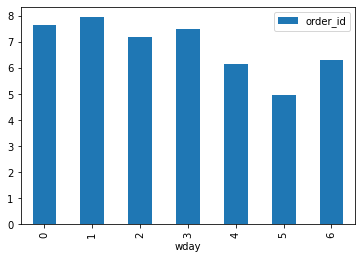

In [33]:
(
    data
    .groupby([ 'date', 'wday']).agg({'order_id':'nunique'})
    .pivot_table(index = 'wday', values = 'order_id', aggfunc = 'mean')
    .plot.bar()
);

В среднем в день у онлайн-магазина от 5 до 8 заказов. С пятницы по воскресенье в среднем покупают чуть реже, чем в остальные дни.

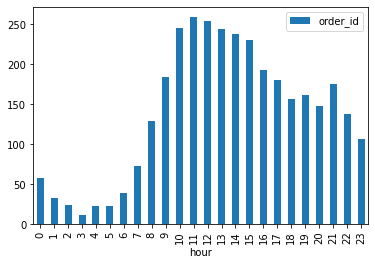

In [34]:
data.pivot_table(index = 'hour', values = 'order_id', aggfunc = 'nunique').plot.bar();

Чаще всего заказывали с 9 до 15 часов, реже всего - с 0 до 7 часов.

#### Распределение кол-ва заказов и доходов магазина по месяцам

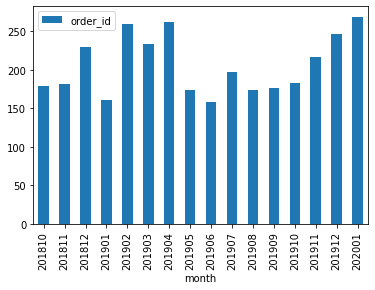

In [35]:
data.pivot_table(index = 'month', values = 'order_id', aggfunc = 'nunique').plot.bar();

Кол-во заказов в январе 2019 и июне 2019 опускалось до минимального за период - около 150 заказов за месяц. Больше всего заказов в 1029 году было с февраля по апрель (по-видимму, садоводы готовились к сезону). С ноября 2019 по январь 2020 заметный рост количества заказов - интересно с чем связан, кажется, что нельзя объяснить его сезонностью с учетом того, что в девабре 2019 была просадка. Посмотрим ниже внимательнее как в это периоды продавались товары из разных категорий.

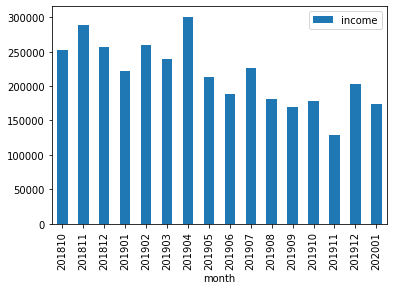

In [36]:
(data
     .groupby(['order_id', 'month'])
     .agg({'income':'sum'})
     .reset_index()
).pivot_table(index = 'month', values = 'income', aggfunc = 'sum').plot.bar();

Интересно, что при росте числа заказов в конце 2019 и начале 2020 года общий доход магазина с середины 2019 года снижается.

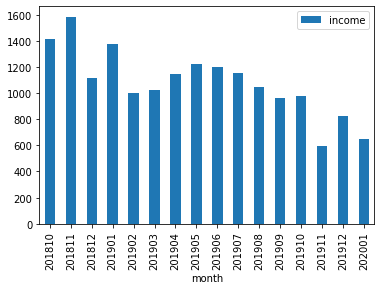

In [37]:
(data
     .groupby(['order_id', 'month'])
     .agg({'income':'sum'})
     .reset_index()
).pivot_table(index = 'month', values = 'income', aggfunc = np.mean).plot.bar();

Закономерно, средняя выручка магазина во второй половине 2019-начале 2020 снижается.

### Анализ ассортимента - какие категории, какие чаще покупают, какая сезонность

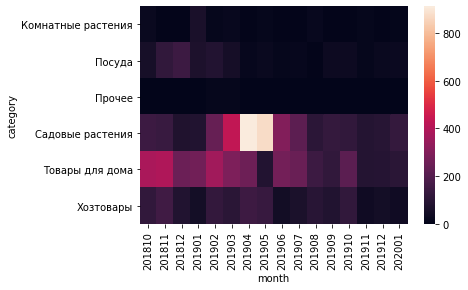

In [38]:
sns.heatmap(data.pivot_table(index = 'category', columns = 'month', values = 'quantity', aggfunc = 'sum').fillna(0));

Особенно много (в терминах количества единиц купленного товара) покупали в апреле-мае 2019 в категории Садовые растения. 

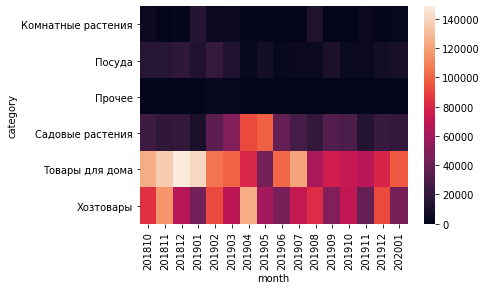

In [39]:
sns.heatmap(data.pivot_table(index = 'category', columns = 'month', values = 'income', aggfunc = 'sum').fillna(0));

- В течение всего периода большую часть выручки магазина состаляла продажи в категориях Товары для дома и Хозтовары. При этом видно, что пик продаж в категории Товары для дома пришелся на конец 2018 - янв 2019, потом продажи стали падать.
- В апреле-мае 2019 большой доход магазину принесли продажи в категории Садовые растения (на предыдущем хитмэпе видели, что товаров в этой категории в этот период продавалось много). 

Посмотрим на динмаику изменения доходов и количества проданных товаров в каждой категории со временем.

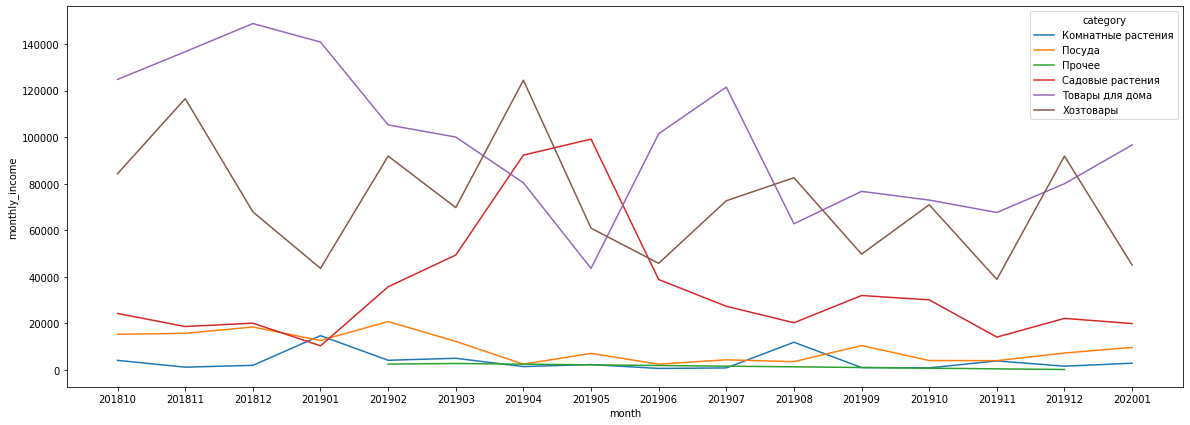

In [40]:
# динамика изменения выручки по категориям
plt.figure(figsize=(20,7))
sns.lineplot(data = data.groupby(['category', 'month']).agg(monthly_income = ('income', 'sum')).reset_index(), \
             x = 'month', y = 'monthly_income', hue = 'category');

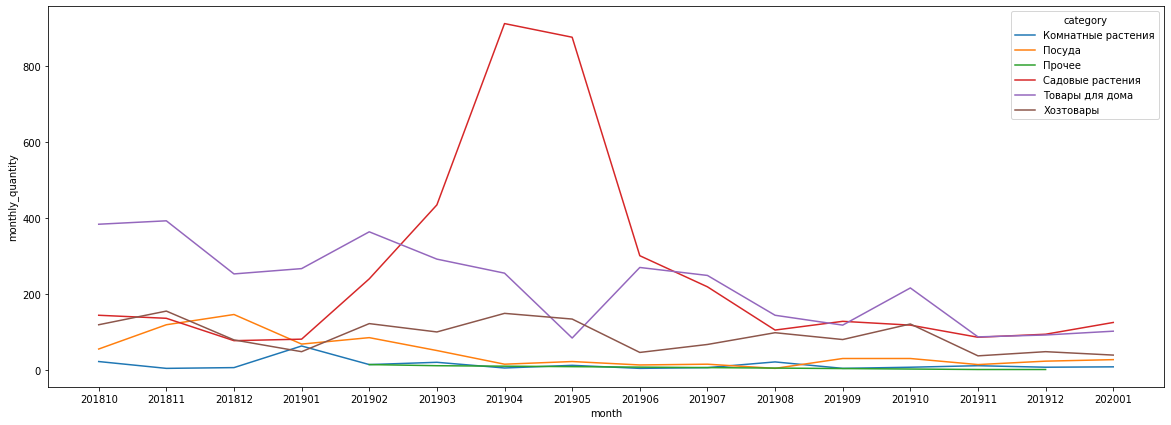

In [41]:
# динамика изменения кол-ва проданных товаров по категориям
plt.figure(figsize=(20,7))
sns.lineplot(data = data.groupby(['category', 'month']).agg(monthly_quantity = ('quantity', 'sum')).reset_index(), \
             x = 'month', y = 'monthly_quantity', hue = 'category');

На этом графике также видно, что продажи в категории Товары для дома планомерно снижались весь период наблюдения - возможно, это связано с выводом из ассортимента какого-то популрного товара, проверим.

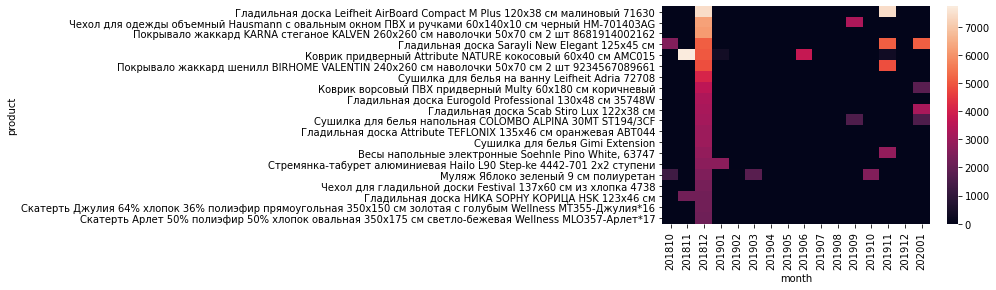

In [42]:
sns.heatmap(
    ( 
    data
    .query('category == "Товары для дома"')
    .pivot_table(columns = 'month', index = 'product', values = 'income', aggfunc = 'sum')
    .fillna(0)
    .sort_values(by=['201812','201912', '202001'], ascending=False)
).head(20));

Видно, что большинство из топ-20 самых дорогих товаров в категории Товары для дома на декабрь 2018 ни разу не купили в январе 2020 - возможно, они исчезли из авссортимента, может, есть технические проблемы на сайте с этими товарами, возможно какая-то другая причина - в любом случае, нужна дополнительная проработка с бизнесом для установления причин падения продаж.

### Сегментация клиентов с помощью  RFM-анализа

Сформируем табличку с профилями покупателей для дальнейшего RFM анализа. Столбцы: customer_id, recency (сколько дней прошло с последнего заказа), frequency (кол-во заказов за период), monetary (общая сумма трат за период).

In [43]:
lastday = data.date.max()

In [44]:
rfm_table = data.groupby('customer_id').agg({'date': lambda x: (lastday - x.max()).days, # Recency
                                                'order_id': lambda x: len(x.unique()), # Frequency
                                                'income': lambda x: x.sum()}).sort_values(by = 'order_id') 

rfm_table.rename(columns={'date': 'recency', 
                         'order_id': 'frequency',
                         'income': 'monetary_value'}, inplace=True)
rfm_table.head()

,recency,frequency,monetary_value
customer_id,,,
000d6849-084e-4d9f-ac03-37174eaf60c4,107,1,555.0
99e728ef-b118-477d-95a1-3dab449d2db1,417,1,2324.0
9990ce3c-995c-4990-8dc5-75583a0c11d2,317,1,225.0
9988a59f-f1ec-4f0c-bb3e-cd0e235ad15e,169,1,2658.0
997658b1-66c1-4858-a852-50b2d33f2eaf,227,1,239.0


In [45]:
#data[data.customer_id == 'c971fb21-d54c-4134-938f-16b62ee86d3b'].sort_values(by = 'income')

In [46]:
quantiles = rfm_table.quantile(q=[0.25,0.5,0.75])
quantiles

,recency,frequency,monetary_value
0.25,72.0,1.0,389.0
0.50,205.0,1.0,826.5
0.75,342.5,2.0,1776.0


Добавим в табличку квантили recency, frequency, monetary - от 1 до 4 (в какой квартиль попадает соответствующее значение).  

In [47]:
quantiles = quantiles.to_dict()
rfm_segment = rfm_table.copy()

# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def R_Class(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
    
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FM_Class(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
rfm_segment['r_quartile'] = rfm_segment['recency'].apply(R_Class, args=('recency',quantiles,))
rfm_segment['f_quartile'] = rfm_segment['frequency'].apply(FM_Class, args=('frequency',quantiles,))
rfm_segment['m_quartile'] = rfm_segment['monetary_value'].apply(FM_Class, args=('monetary_value',quantiles,))
rfm_segment['rfm_class'] = rfm_segment.r_quartile.map(str) \
                            + rfm_segment.f_quartile.map(str) \
                            + rfm_segment.m_quartile.map(str)

In [48]:
rfm_segment.head(5)

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,rfm_class
customer_id,,,,,,,
000d6849-084e-4d9f-ac03-37174eaf60c4,107,1,555.0,3,1,2,312
99e728ef-b118-477d-95a1-3dab449d2db1,417,1,2324.0,1,1,4,114
9990ce3c-995c-4990-8dc5-75583a0c11d2,317,1,225.0,2,1,1,211
9988a59f-f1ec-4f0c-bb3e-cd0e235ad15e,169,1,2658.0,3,1,4,314
997658b1-66c1-4858-a852-50b2d33f2eaf,227,1,239.0,2,1,1,211


In [49]:
rfm_segment.rfm_class.value_counts()

434    196
433    161
211    154
111    151
311    148
212    146
112    143
113    142
432    131
114    125
213    125
312    107
214    100
431     99
313     98
314     67
334     57
333     49
332     36
331     27
234     22
232     15
233     12
134     12
132      9
411      8
231      8
244      8
131      6
133      5
414      4
344      3
242      3
243      3
144      3
412      2
341      1
343      1
142      1
143      1
342      1
413      1
Name: rfm_class, dtype: int64

In [50]:
#добавим столбец с названием сегмента клиента на основании rfm_class
rfm_segment['cust_segment'] = None

In [51]:
# недавно, часто и много - идеальные клиенты
rfm_segment.loc[(rfm_segment.r_quartile > 2) & (rfm_segment.f_quartile > 2) & (rfm_segment.m_quartile > 2 ), 'cust_segment'] =\
'идеальные'

In [52]:
# нечасто, но много или часто понемного и недавно - перспективные клиенты
rfm_segment.loc[(rfm_segment.r_quartile >2) & (((rfm_segment.f_quartile <=2) & (rfm_segment.m_quartile > 2)) | ((rfm_segment.f_quartile >=2) & (rfm_segment.m_quartile <= 2))), 'cust_segment'] =\
'перспективные'

In [53]:
# недавно, нечасто, немного - менее перспективные
rfm_segment.loc[(rfm_segment.r_quartile > 2) & (rfm_segment.f_quartile <= 2) & (rfm_segment.m_quartile <= 2 ), 'cust_segment'] =\
'менее перспективные'

In [54]:
#Бывшие лояльные - часто и давно или много и давно
rfm_segment.loc[(rfm_segment.r_quartile <= 2) & ((rfm_segment.f_quartile > 2) | (rfm_segment.m_quartile > 2 )), 'cust_segment'] =\
'Бывшие лояльные'

In [55]:
# давно, нечасто и немного - неперспективные
rfm_segment.loc[(rfm_segment.r_quartile <= 2) & (rfm_segment.f_quartile <= 2) & (rfm_segment.m_quartile <= 2 ), 'cust_segment'] =\
'неперспективные'

In [56]:
# посмотрим на распределение классов по сегментам и убедимся, что всем классам соответствует сегмент
print(rfm_segment['cust_segment'].value_counts())
print('Кол-во пустых значений в столбце cust_segment: ', rfm_segment['cust_segment'].isna().sum())

Бывшие лояльные        600
неперспективные        594
идеальные              467
перспективные          465
менее перспективные    265
Name: cust_segment, dtype: int64
Кол-во пустых значений в столбце cust_segment:  0


### Выводы по исследовательскому анализу данных

установили, что продажи магазина во второй половине 2019 и в начале 2020 года снижались, преимущественно из-за снижения продаж в категории Товары для дома - необходимо дополнительное обсуждение с бизнесом для уточнения причин .
- Провели сегментацию покупателей с помощью RFM-анализа. Выделили следующие сегменты покупателей: 

(1) идеальные - покупали недавно, при этом покупают много, часто. Таким клиентам достаточно напоминать о себе, покупать ои, вероятнее всего, будут даже товары без скидок/персональных предложений

(2) перспективные - те, что покупали недавно, при этом покупают нечасто, но много или часто понемного. Таким клиентам можно предлагать скидки и спецпредложения для роста лояльности к магазину - основной фокус работы должен быть на этих клиентах

(3) менее перспективные - покупали недавно, но в отличие от сегмента Перспективные покупают нечасто и немного - можно работать над повышением лояльности этой группы покупателей, пробовать увеличить средний чек этой группы с помощьб акций - но это не основной фокус

(4) Бывшие лояльные - покупали часто и давно или много и давно - таких клиентов надо постараться вернуть, попробовать начать просто с того, что напомнить о магазине рассылкой , потенциально эти клиенты могут пеерйти в категорию идеальных

(5) неперспективные - покупали давно, нечасто и немного - эти клиенты не в фокусу работы маркетологов

## Проверка статистических гипотез

Сформулировать стат гипотезы, чтобы убедиться, что поведение клиентов из разных сегментов действительно различается.

In [57]:
#добавим в датасет data колоку с сегментом, к которому отнесли покупателя
data = data.merge(rfm_segment['cust_segment'].reset_index(), on = 'customer_id')

Проверим, является ли распределение в выборках, для которых булем проводить стат тесты, нормальным. Если да - для проерки гипотез будем использовать t-тест, если распределение ненормально - будем использовать критерий Манна — Уитни.

In [58]:
sample1 = data.query('cust_segment == "идеальные"').groupby('order_id').agg('income').sum()
sample2 = data.query('cust_segment == "перспективные"').groupby('order_id').agg('income').sum()
sample3 = data.query('cust_segment == "Бывшие лояльные"').groupby('order_id').agg('income').sum() 
sample4 = data.query('cust_segment == "менее перспективные"').groupby('order_id').agg('income').sum()
sample5 = data.query('cust_segment == "неперспективные"').groupby('order_id').agg('income').sum()

In [59]:
#проверка данных на нормальность
alpha = 0.05  # критический уровень статистической значимости

for s in rfm_segment['cust_segment'].unique():
    sample = data.query('cust_segment == @s').groupby('order_id').agg('income').sum()
    results = st.shapiro(sample)
    p_value = results[1]
    print('выборка для сегмента ', s)
    print('p-значение: ', p_value)
    
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: распределение не нормально')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, всё нормально') 

выборка для сегмента  менее перспективные
p-значение:  1.7084815784329521e-09
Отвергаем нулевую гипотезу: распределение не нормально
выборка для сегмента  Бывшие лояльные
p-значение:  3.9404512816813856e-42
Отвергаем нулевую гипотезу: распределение не нормально
выборка для сегмента  неперспективные
p-значение:  1.004983639710244e-12
Отвергаем нулевую гипотезу: распределение не нормально
выборка для сегмента  перспективные
p-значение:  2.2775303940671252e-41
Отвергаем нулевую гипотезу: распределение не нормально
выборка для сегмента  идеальные
p-значение:  1.6665414751453587e-35
Отвергаем нулевую гипотезу: распределение не нормально


- Поскольку распределения не являются нормальными, будем использовать критерий Манна-Уитни. 
- Для каждой пары сегментов покупателей будем проверять H0-гипотезу о равенстве средних чеков и равенстве средних количествах заказов. 
- H1-гипотеза: средние секи/среднее количество заказов для двух сегментов не равны.

In [60]:
def stat_test():
    for k,v in {'средний чек': {'income':'sum'}, 'среднее число заказов': {'order_id':'count'}}.items():
            print('Статистический тест для ', k)
            print()
            
            for s in list(itertools.combinations(rfm_segment['cust_segment'].unique(), 2)):
                sample1 = data.query('cust_segment == @s[0]').groupby('order_id').agg(v)
                sample2 = data.query('cust_segment == @s[1]').groupby('order_id').agg(v)
                
                print('Ищем статистическое различие между сегментами ', s[0], ' и ', s[1])
                results = st.mannwhitneyu(sample1, sample2)
                p_value = results[1]
                print('p-значение: ', p_value)  
                
                if p_value < alpha:
                    print('Отвергаем нулевую гипотезу. Различия между сегментами есть')
                else:
                    print('Не получилось отвергнуть нулевую гипотезу, различия между сегментами незначимы') 
                    
                print()

In [61]:
stat_test()

Статистический тест для  средний чек

Ищем статистическое различие между сегментами  менее перспективные  и  Бывшие лояльные
p-значение:  [3.94972354e-81]
Отвергаем нулевую гипотезу. Различия между сегментами есть

Ищем статистическое различие между сегментами  менее перспективные  и  неперспективные
p-значение:  [0.00063048]
Отвергаем нулевую гипотезу. Различия между сегментами есть

Ищем статистическое различие между сегментами  менее перспективные  и  перспективные
p-значение:  [0.53976436]
Не получилось отвергнуть нулевую гипотезу, различия между сегментами незначимы

Ищем статистическое различие между сегментами  менее перспективные  и  идеальные
p-значение:  [6.7095375e-31]
Отвергаем нулевую гипотезу. Различия между сегментами есть

Ищем статистическое различие между сегментами  Бывшие лояльные  и  неперспективные
p-значение:  [1.03260979e-125]
Отвергаем нулевую гипотезу. Различия между сегментами есть

Ищем статистическое различие между сегментами  Бывшие лояльные  и  перспектив

### Выводы по проверке гипотез

- Провериои распределения выборок на нормальность и установили, что распределения не являются нормальными. Поэтому для проверки статистических гипотез применяли тест Манни-Уитни.
- Для каждой пары сегментов покупателей проверили H0-гипотезу о равенстве средних чеков и равенстве средних количествах заказов. H1-гипотеза: средние секи/среднее количество заказов для двух сегментов не равны.
- Не удалось установить статистически значимое различие в средних чеках у сегментов менее перспективные  и  перспективные, однако тест для кол-ва заказов показал значимое различие. Не будем переделывать эти сегменты, т.к. методы удержания и работы с этими покупутелями могут отличаться.
- Не удалось установить различие в среднем кол-ве заказов у сегментов  перспективные  и  идеальные - однако также не будем менять сегментацию, т.к. методы работы с этими группами покупателей могут отличаться (например, перспективным клиентам можно предложить скидку или другое персональное предложение, а идеальные покупатели будут покупать у нас и без скидки).

## Выводы по проекту

- На входе имели данные за период с 01.10.2018 по   31.01.2020, всего 7474 строк и 6 столбцов.
- В результате предобработки данных (удаления неявных дубликатов, выбросов) осталось 5317 строк. Были добавлены новые столбцы для удобства работы с датами, добавлены категории товаров.
- В рамках исследовательского анализа данных установили, что продажи магазина во второй половине 2019 и в начале 2020 года снижались, преимущественно из-за снижения продаж в категории Товары для дома - необходимо дополнительное обсуждение с бизнесом для уточнения причин .
- Провели сегментацию покупателей с помощью RFM-анализа. Выделили следующие сегменты покупателей: 

(1) идеальные - покупали недавно, при этом покупают много, часто. Таким клиентам достаточно напоминать о себе, покупать ои, вероятнее всего, будут даже товары без скидок/персональных предложений

(2) перспективные - те, что покупали недавно, при этом покупают нечасто, но много или часто понемного. Таким клиентам можно предлагать скидки и спецпредложения для роста лояльности к магазину - основной фокус работы должен быть на этих клиентах

(3) менее перспективные - покупали недавно, но в отличие от сегмента Перспективные покупают нечасто и немного - можно работать над повышением лояльности этой группы покупателей, пробовать увеличить средний чек этой группы с помощьб акций - но это не основной фокус

(4) Бывшие лояльные - покупали часто и давно или много и давно - таких клиентов надо постараться вернуть, попробовать начать просто с того, что напомнить о магазине рассылкой , потенциально эти клиенты могут пеерйти в категорию идеальных

(5) неперспективные - покупали давно, нечасто и немного - эти клиенты не в фокусу работы маркетологов

- Установили, что сегменты имеют статистически значимые различия.